# Baseline Modeling - Naive Bayes & Logistic Regression

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import col, split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import json

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import re

from langdetect import detect

import pickle

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sineadoconnor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [3]:
fastFoodDF = spark.read.json('../SavedFiles/fastFood.json')

## Pre-processing the text

### Removing Non-English Reviews

In [4]:
def lang_filter(text):
    """Filter non-english reviews"""
    try:
        if detect(text) == 'en':
            return 'english'
        else:
            return 'other'
    except:
        return '?'

#my computer  cannot run this on full set of reviews this so I will do some other filtering first

In [5]:
#tokenize the reviews

from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType
import string

punc = [ch for ch in string.punctuation] 

tok_udf = udf((lambda text: " ".join([w for w in wordpunct_tokenize(text.lower()) if w.isalpha() or w in punc])), 
              StringType())

fastFoodDF = fastFoodDF = fastFoodDF.withColumn('text_tok', tok_udf(fastFoodDF.text))

In [6]:
sw = stopwords.words('english')
sw = word_tokenize(' '.join([w for w in sw]))
sw = sw + ['.', ',', '...', '\'\'', '\"', '``', '¡',  '{','|','||','}', '(',')']

In [7]:
fren = set(stopwords.words('french'))
for word in ['on','me','s','t', 'ton', 'son','m','d','n','as']:
    fren.remove(word)
span = set(stopwords.words('spanish'))
for word in ['no','a','he','me','has','son']:
    span.remove(word)
ger = set(stopwords.words('german'))
for word in ['am', 'an', 'in','im','die','dies','also','war', 'hat', 'man', 'so', 'was','will']:
    ger.remove(word)

In [8]:
fren

{'ai',
 'aie',
 'aient',
 'aies',
 'ait',
 'au',
 'aura',
 'aurai',
 'auraient',
 'aurais',
 'aurait',
 'auras',
 'aurez',
 'auriez',
 'aurions',
 'aurons',
 'auront',
 'aux',
 'avaient',
 'avais',
 'avait',
 'avec',
 'avez',
 'aviez',
 'avions',
 'avons',
 'ayant',
 'ayante',
 'ayantes',
 'ayants',
 'ayez',
 'ayons',
 'c',
 'ce',
 'ces',
 'dans',
 'de',
 'des',
 'du',
 'elle',
 'en',
 'es',
 'est',
 'et',
 'eu',
 'eue',
 'eues',
 'eurent',
 'eus',
 'eusse',
 'eussent',
 'eusses',
 'eussiez',
 'eussions',
 'eut',
 'eux',
 'eûmes',
 'eût',
 'eûtes',
 'furent',
 'fus',
 'fusse',
 'fussent',
 'fusses',
 'fussiez',
 'fussions',
 'fut',
 'fûmes',
 'fût',
 'fûtes',
 'il',
 'ils',
 'j',
 'je',
 'l',
 'la',
 'le',
 'les',
 'leur',
 'lui',
 'ma',
 'mais',
 'mes',
 'moi',
 'mon',
 'même',
 'ne',
 'nos',
 'notre',
 'nous',
 'ont',
 'ou',
 'par',
 'pas',
 'pour',
 'qu',
 'que',
 'qui',
 'sa',
 'se',
 'sera',
 'serai',
 'seraient',
 'serais',
 'serait',
 'seras',
 'serez',
 'seriez',
 'serions',
 '

In [9]:
span

{'al',
 'algo',
 'algunas',
 'algunos',
 'ante',
 'antes',
 'como',
 'con',
 'contra',
 'cual',
 'cuando',
 'de',
 'del',
 'desde',
 'donde',
 'durante',
 'e',
 'el',
 'ella',
 'ellas',
 'ellos',
 'en',
 'entre',
 'era',
 'erais',
 'eran',
 'eras',
 'eres',
 'es',
 'esa',
 'esas',
 'ese',
 'eso',
 'esos',
 'esta',
 'estaba',
 'estabais',
 'estaban',
 'estabas',
 'estad',
 'estada',
 'estadas',
 'estado',
 'estados',
 'estamos',
 'estando',
 'estar',
 'estaremos',
 'estará',
 'estarán',
 'estarás',
 'estaré',
 'estaréis',
 'estaría',
 'estaríais',
 'estaríamos',
 'estarían',
 'estarías',
 'estas',
 'este',
 'estemos',
 'esto',
 'estos',
 'estoy',
 'estuve',
 'estuviera',
 'estuvierais',
 'estuvieran',
 'estuvieras',
 'estuvieron',
 'estuviese',
 'estuvieseis',
 'estuviesen',
 'estuvieses',
 'estuvimos',
 'estuviste',
 'estuvisteis',
 'estuviéramos',
 'estuviésemos',
 'estuvo',
 'está',
 'estábamos',
 'estáis',
 'están',
 'estás',
 'esté',
 'estéis',
 'estén',
 'estés',
 'fue',
 'fuera',

In [10]:
ger

{'aber',
 'alle',
 'allem',
 'allen',
 'aller',
 'alles',
 'als',
 'ander',
 'andere',
 'anderem',
 'anderen',
 'anderer',
 'anderes',
 'anderm',
 'andern',
 'anderr',
 'anders',
 'auch',
 'auf',
 'aus',
 'bei',
 'bin',
 'bis',
 'bist',
 'da',
 'damit',
 'dann',
 'das',
 'dass',
 'dasselbe',
 'dazu',
 'daß',
 'dein',
 'deine',
 'deinem',
 'deinen',
 'deiner',
 'deines',
 'dem',
 'demselben',
 'den',
 'denn',
 'denselben',
 'der',
 'derer',
 'derselbe',
 'derselben',
 'des',
 'desselben',
 'dessen',
 'dich',
 'diese',
 'dieselbe',
 'dieselben',
 'diesem',
 'diesen',
 'dieser',
 'dieses',
 'dir',
 'doch',
 'dort',
 'du',
 'durch',
 'ein',
 'eine',
 'einem',
 'einen',
 'einer',
 'eines',
 'einig',
 'einige',
 'einigem',
 'einigen',
 'einiger',
 'einiges',
 'einmal',
 'er',
 'es',
 'etwas',
 'euch',
 'euer',
 'eure',
 'eurem',
 'euren',
 'eurer',
 'eures',
 'für',
 'gegen',
 'gewesen',
 'hab',
 'habe',
 'haben',
 'hatte',
 'hatten',
 'hier',
 'hin',
 'hinter',
 'ich',
 'ihm',
 'ihn',
 'ihn

In [11]:
fren_span_ger = set(list(fren)+list(span)+list(ger))

In [12]:
#to check for foreign stopwords and non-ascii characters

not_eng_udf = udf((lambda text: [w for w in word_tokenize(text) if w.lower() in fren_span_ger or not w.isascii()]), 
                  ArrayType(StringType()))

tempDF = fastFoodDF.withColumn('not_eng', not_eng_udf(fastFoodDF.text_tok))

In [13]:
tempDF = tempDF.toPandas()

In [14]:
tempDF['num_non_eng'] = tempDF.not_eng.apply(lambda x: len(x)) 

In [15]:
maybe_eng = tempDF[(tempDF.num_non_eng != 0)]
maybe_eng

,business_id,city,date,name,review_id,stars,state,text,useful,word_count,text_tok,not_eng,num_non_eng
1,aZOoc-87ESqy8apJO3J-Yw,Gilbert,2017-05-28 23:01:26,Slim Chickens,ZbFJnkkPQ_fiUw0FJKzLbg,5.0,AZ,What a welcome concept in fast food. Cute pla...,0,83,what a welcome concept in fast food . cute pla...,[jalapeño],1
6,OUB81Dpb6m7HjW4ZmeSlmw,Toronto,2016-03-21 18:55:27,Mean Bao,BKnvzGnsxLDN-EnIvM5A6A,3.0,ON,Mostly known for their pork belly bao. They ar...,0,108,mostly known for their pork belly bao . they a...,[mi],1
17,KpG24S0VRTvPqNh_qC-wLg,Peoria,2017-02-14 00:10:26,In-N-Out Burger,tStwqk0iRrZSH9fuYRnj7A,5.0,AZ,ハンバーガーといえばこのお店で間違いありません。タマネギを入れるか入れないか、入れるタマネギ...,0,4,ハンバーガーといえばこのお店で間違いありません タマネギを入れるか入れないか 入れるタマネギ...,"[ハンバーガーといえばこのお店で間違いありません, タマネギを入れるか入れないか, 入れるタ...",4
29,dKdApYVFDSNYsNOso6NYlA,Las Vegas,2015-04-19 06:59:59,White Castle,J2flqJShtx3YIeI2fe_MHg,5.0,NV,"""It taste so good when it hits the lips!""\n\nT...",1,83,""" it taste so good when it hits the lips this ...",[las],1
33,dKdApYVFDSNYsNOso6NYlA,Las Vegas,2015-02-06 19:43:18,White Castle,DRyF25xToznKWQZVJNCMdA,4.0,NV,I see a lot of bad ratings about this place an...,8,358,i see a lot of bad ratings about this place an...,[las],1
51,19wIOjBlI_2EKGM8E4O6Mg,Las Vegas,2015-07-20 02:03:52,Quiznos,pDEIHJqEpFLskKobYZZLew,3.0,NV,"It's been a few years since a review here, so ...",0,266,"it ' s been a few years since a review here , ...",[las],1
52,M7gB_MsmKwjSO8pk1rQ00w,Toronto,2015-12-08 06:11:43,Cucinetta,fnbRRpm4VcYzlmW-ESdflw,1.0,ON,I came here after a long study session and sup...,1,424,i came here after a long study session and sup...,[al],1
58,e8wPL-2r2F6-7ucb_VOilA,Mesa,2016-07-19 18:54:13,Jimmy John's,rQRrcq2KCCA3GVs7lybCzw,1.0,AZ,Las Sendas is maybe a 3 minute drive from this...,2,42,las sendas is maybe a minute drive from this l...,[las],1
59,pSMK_FtULKiU-iuh7SMKwg,Toronto,2016-04-16 22:43:36,Blaze Fast-Fire'd Pizza,OOc6O8OdSrhrA7PX7DmUEQ,4.0,ON,Menu: http://www.blazepizza.com/menu/\n\nWhat ...,1,241,menu : http www . blazepizza . com / menu / wh...,[ne],1
78,vnYtZv_GA_2Xfi2DefbvCg,Saint-Laurent,2018-07-11 17:36:35,La Cage aux Sports,CJnXfhj5iW4EAGjlqyjiqA,3.0,QC,It's been great for a quick lunch menu. Been t...,0,91,it ' s been great for a quick lunch menu . bee...,[jalapeño],1


In [16]:
maybe_eng.shape
#some of these are clearly  english
#hopefully langdetect can handle 23510 on my computer...

(23180, 13)

In [17]:
maybe_eng['lang'] = maybe_eng.text.apply(lang_filter)

/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
not_eng = maybe_eng[maybe_eng.lang == 'other']
not_eng

,business_id,city,date,name,review_id,stars,state,text,useful,word_count,text_tok,not_eng,num_non_eng,lang
17,KpG24S0VRTvPqNh_qC-wLg,Peoria,2017-02-14 00:10:26,In-N-Out Burger,tStwqk0iRrZSH9fuYRnj7A,5.0,AZ,ハンバーガーといえばこのお店で間違いありません。タマネギを入れるか入れないか、入れるタマネギ...,0,4,ハンバーガーといえばこのお店で間違いありません タマネギを入れるか入れないか 入れるタマネギ...,"[ハンバーガーといえばこのお店で間違いありません, タマネギを入れるか入れないか, 入れるタ...",4,other
117,a7shUJaC5xM_BHODzuCR9Q,Montréal,2018-02-05 02:25:16,Thai Express,PJQrJWDzYnY94_TeK9JzjA,3.0,QC,"C'est de la nourriture ""thai"" américanisé diso...",0,111,"c ' est de la nourriture "" thai "" américanisé ...","[c, est, de, la, américanisé, le, végé, ce, qu...",62,other
330,_WeqzDfTUEBMbxj70tDtGQ,Montréal,2018-09-05 22:02:54,McDonald's,CaPHprKveWaHyUEal1MTPA,1.0,QC,"Le service à la clientèle est à revoir, car le...",0,58,"le service à la clientèle est à revoir , car l...","[le, à, la, clientèle, est, à, le, est, très, ...",32,other
747,SJAggfn8ta7XLD98XD2mkw,Dorval,2017-02-24 22:58:32,QDC Burger,8yihTT7SkaHW3w6usfcRjw,5.0,QC,Faut pas bouder son plaisir. Évidemment c'est ...,0,62,faut pas bouder son plaisir . évidemment c ' e...,"[pas, évidemment, c, est, un, mais, c, est, dr...",36,other
1007,zHAR8MmCbjrkNnLGm1ozEQ,Henderson,2017-05-02 18:42:46,Rivas Mexican Grill,9WAwwPGkMTD_2MqH5xkJQg,5.0,NV,Rivas mexican grill sin duda alguna lo recomie...,1,40,rivas mexican grill sin duda alguna lo recomie...,"[sin, lo, de, es, una, hay, algo, este, en, el...",18,other
1029,_WeqzDfTUEBMbxj70tDtGQ,Montréal,2015-06-13 02:58:05,McDonald's,POlX2suoHJi385Ah4QcXoA,1.0,QC,Service très lent. La caisse est toujours ferm...,1,21,service très lent . la caisse est toujours fer...,"[très, la, est, fermée, au, à, la, clientèle, ...",10,other
1095,9qaVihZntKq-0MoE-wHYwA,Coteau-du-Lac,2015-08-22 12:19:47,Brochetterie Naxos,nJGn78k3vQsERUgKDR5Ijw,4.0,QC,"""Convenablement modeste et convivial avec bonn...",0,306,""" convenablement modeste et convivial avec bon...","[et, avec, nous, y, étions, allés, à, de, par,...",184,other
1222,kpjkIJl4LIUy-ba_jzLKEA,St. Léonard,2018-05-03 22:39:26,Harvey's,u6hk74j6BphPwlP4T7vq2A,3.0,QC,J'adore Harvey's! J'aime bcp leurs hamburgers ...,0,23,j ' adore harvey ' s ! j ' aime bcp leurs hamb...,"[j, j, à, la, clientèle, très, des, qui, y, très]",10,other
1397,6KyDIOGT9EAzq1w4kb77ow,Montreal-Nord,2010-12-03 01:41:16,Da Bologna,jt6YF8q-FctcxphgNwn1pg,4.0,QC,Da Bologna est véritablement le bijou de Montr...,6,95,da bologna est véritablement le bijou de montr...,"[da, est, véritablement, le, de, montréal, en,...",59,other
1555,zWPCyy1VEqoO3J_IcUWDTQ,Montréal,2010-12-04 05:55:32,Le Saint-Sulpice,OQ9QBoPdjl9rZzvxpaXOlg,3.0,QC,"Au cœur du quartier latin, le Saint-Sulpice, c...",3,208,"au cœur du quartier latin , le saint - sulpice...","[au, cœur, du, le, communément, un, montréalai...",108,other


In [19]:
not_eng.shape

(843, 14)

In [20]:
maybe_eng[maybe_eng.lang == '?']

,business_id,city,date,name,review_id,stars,state,text,useful,word_count,text_tok,not_eng,num_non_eng,lang


In [21]:
tempDF = tempDF.drop(not_eng.index)

In [22]:
tempDF.shape

(219664, 13)

In [23]:
fastFood_eng = tempDF

In [24]:
#fastFood_eng = spark.createDataFrame(tempDF)

## Make X and y 

In [25]:
def make_xy(reviewDF, vectorizer=None, min_df = 1, max_df = 1.0):
    if vectorizer is None:
        print('The value of vectorizer is None ... using CountVectorizer')
    else:
        print('The value of vectorizer is NOT None ... using the provided vectorizer')
    #
    if vectorizer is None:
        vectorizer = CountVectorizer(strip_accents = 'ascii', stop_words = sw, 
                                     min_df = min_df, max_df = max_df)
    X = vectorizer.fit_transform(reviewDF.text_tok)
    X = X.tocsc() 
    y = reviewDF.stars
    return X, y, vectorizer 


In [26]:
X, y, vectorizer = make_xy(fastFood_eng)

The value of vectorizer is None ... using CountVectorizer


In [27]:
n_rows, n_cols = X.shape
print('Number of reviews: ', n_rows)
print('Number of terms: ', n_cols)

Number of reviews:  219664
Number of terms:  72084


In [28]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=123)

nb = MultinomialNB()
nb.fit(Xtrain, ytrain)
train_accuracy = nb.score(Xtrain, ytrain)
test_accuracy = nb.score(Xtest, ytest)

print("[Training Classification Report:]")
print(classification_report(ytrain, nb.predict(Xtrain)))
print('Training Accuracy: ',train_accuracy)
print('')
print("[Test Classification Report:]")
print(classification_report(ytest, nb.predict(Xtest)))
print('Test Accuracy: ', test_accuracy)


[Training Classification Report:]
              precision    recall  f1-score   support

         1.0       0.72      0.84      0.78     42004
         2.0       0.47      0.32      0.38     18620
         3.0       0.54      0.43      0.48     21441
         4.0       0.56      0.55      0.55     34079
         5.0       0.73      0.79      0.76     48604

   micro avg       0.65      0.65      0.65    164748
   macro avg       0.60      0.59      0.59    164748
weighted avg       0.64      0.65      0.64    164748

Training Accuracy:  0.6528819773229417

[Test Classification Report:]
              precision    recall  f1-score   support

         1.0       0.70      0.82      0.76     13981
         2.0       0.34      0.23      0.28      6207
         3.0       0.40      0.32      0.35      7093
         4.0       0.48      0.48      0.48     11552
         5.0       0.70      0.75      0.72     16083

   micro avg       0.60      0.60      0.60     54916
   macro avg       0.52    

We see there is overfitting from the gap in training accuracy and testing accuracy.  We will use CDFs of the document frequency to choose the hyperparameters.

In [29]:
feature_names = vectorizer.get_feature_names()

In [30]:
word_frequencies = np.array([X[:,i].count_nonzero() for i in range(n_cols)])

In [31]:
len(word_frequencies[word_frequencies==1])

32753

In [32]:
max_doc_freq = np.max(word_frequencies)
x_values = range(max_doc_freq)
x_values

range(0, 97991)

In [33]:
#what word appears in the most reviews?
most_freq_idx = list(word_frequencies).index(max_doc_freq)
feature_names[most_freq_idx]

'food'

It makes sense that "food" is the word that appears in the most fast food reviews (after removing stop words).

## Hyperparameter Tuning

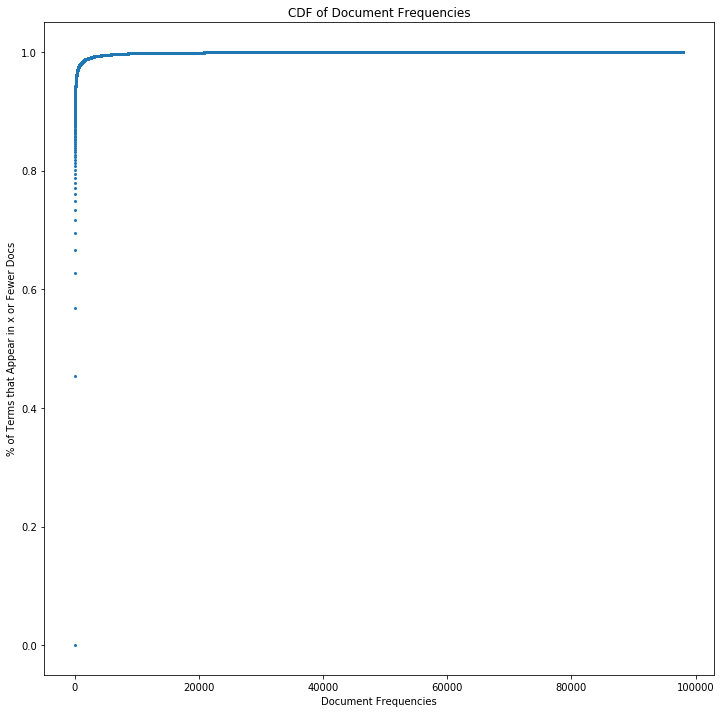

In [34]:
y_values  = np.array([np.sum(word_frequencies <= i) for i in x_values])/n_cols

plt.figure(figsize=(12,12))
plt.plot(x_values,y_values, marker = 'o',markersize = 2, linestyle = 'none')

plt.xlabel('Document Frequencies')
plt.ylabel('% of Terms that Appear in x or Fewer Docs')
plt.title('CDF of Document Frequencies')
plt.savefig('../SavedFiles/CDFofDocFreq')

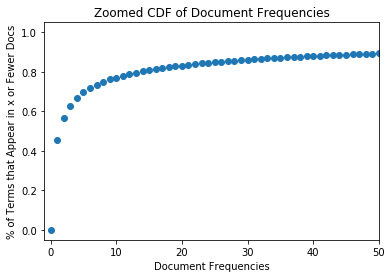

In [35]:
plt.plot(x_values,y_values, marker = 'o',linestyle = 'none')
plt.xlim([-1,50])
plt.xlabel('Document Frequencies')
plt.ylabel('% of Terms that Appear in x or Fewer Docs')
plt.title('Zoomed CDF of Document Frequencies')
plt.savefig('../SavedFiles/ZoomedCDFofDocFreq')

Text(0.5, 1.0, 'Zoomed CDF of Document Frequencies')

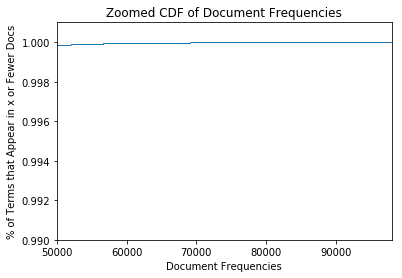

In [36]:
plt.plot(x_values,y_values, marker = '.', markersize = 0.02,linestyle = 'none')
plt.xlim(50000,98000)
plt.ylim(0.99,1.001)
plt.xlabel('Document Frequencies')
plt.ylabel('% of Terms that Appear in x or Fewer Docs')
plt.title('Zoomed CDF of Document Frequencies')

In [37]:
X, y, vectorizer = make_xy(fastFood_eng, min_df = 3, max_df = 70000)

The value of vectorizer is None ... using CountVectorizer


In [38]:
n_rows, n_cols = X.shape
print('Number of reviews: ', n_rows)
print('Number of terms: ', n_cols)

Number of reviews:  219664
Number of terms:  31107


In [39]:
feature_names = vectorizer.get_feature_names()
word_frequencies = np.array([X[:,i].count_nonzero() for i in range(n_cols)])
max_doc_freq = np.max(word_frequencies)
x_values = range(max_doc_freq)
x_values

range(0, 69132)

In [40]:
most_freq_idx = list(word_frequencies).index(max_doc_freq)
feature_names[most_freq_idx]

'good'

## Naive Bayes

In [41]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, random_state=123)

nb = MultinomialNB()
nb.fit(Xtrain, ytrain)
ypred = nb.predict(Xtest)

print("[Training Classification Report:]")
print(classification_report(ytrain, nb.predict(Xtrain)))
print('Training Accuracy: ',accuracy_score(nb.predict(Xtrain), ytrain))
print('')
print("[Test Classification Report:]")
print(classification_report(ytest, ypred))
print('Test Accuracy: ', accuracy_score(ypred, ytest))

[Training Classification Report:]
              precision    recall  f1-score   support

         1.0       0.73      0.82      0.77     42004
         2.0       0.42      0.35      0.38     18620
         3.0       0.50      0.44      0.47     21441
         4.0       0.55      0.52      0.54     34079
         5.0       0.73      0.78      0.75     48604

   micro avg       0.64      0.64      0.64    164748
   macro avg       0.59      0.58      0.58    164748
weighted avg       0.63      0.64      0.63    164748

Training Accuracy:  0.6413188627479545

[Test Classification Report:]
              precision    recall  f1-score   support

         1.0       0.72      0.80      0.76     13981
         2.0       0.34      0.27      0.30      6207
         3.0       0.40      0.35      0.37      7093
         4.0       0.48      0.46      0.47     11552
         5.0       0.70      0.74      0.72     16083

   micro avg       0.59      0.59      0.59     54916
   macro avg       0.53    

There is slightly less overfitting, but the test accuracy is also slightly worse.

In [42]:
confusion_matrix(ytest, ypred)

array([[11219,  1810,   566,   206,   180],
       [ 2353,  1706,  1473,   463,   212],
       [  914,   904,  2502,  2049,   724],
       [  540,   413,  1375,  5316,  3908],
       [  610,   220,   382,  2971, 11900]])

## Logistic Regression

In [43]:
#Cross VALIDATION
param_grid = {'C': [0.001, 0.1, 1, 10, 100]}
logistic = LogisticRegression(solver = 'lbfgs', multi_class = 'auto')
logreg_cv = GridSearchCV(logistic, param_grid, cv = 5)
fitted = logreg_cv.fit(Xtrain, ytrain)
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs 

Tuned Logistic Regression Parameters: {'C': 0.1}
Best score is 0.6246327724767524


/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [44]:
ypred = fitted.predict(Xtest)

print("[Training Classification Report:]")
print(classification_report(ytrain, fitted.predict(Xtrain)))
print('Training Accuracy: ',accuracy_score(fitted.predict(Xtrain), ytrain))
print('')
print("[Test Classification Report:]")
print(classification_report(ytest, ypred))
print('Test Accuracy: ', accuracy_score(ypred, ytest))


[Training Classification Report:]
              precision    recall  f1-score   support

         1.0       0.77      0.91      0.84     42004
         2.0       0.61      0.38      0.47     18620
         3.0       0.60      0.46      0.52     21441
         4.0       0.60      0.52      0.56     34079
         5.0       0.72      0.85      0.78     48604

   micro avg       0.69      0.69      0.69    164748
   macro avg       0.66      0.62      0.63    164748
weighted avg       0.68      0.69      0.68    164748

Training Accuracy:  0.6946184475684075

[Test Classification Report:]
              precision    recall  f1-score   support

         1.0       0.75      0.88      0.81     13981
         2.0       0.43      0.27      0.33      6207
         3.0       0.44      0.35      0.39      7093
         4.0       0.51      0.43      0.46     11552
         5.0       0.68      0.82      0.74     16083

   micro avg       0.63      0.63      0.63     54916
   macro avg       0.56    

In [45]:
confusion_matrix(ytest, ypred)

array([[12307,   949,   292,   143,   290],
       [ 2736,  1660,  1114,   366,   331],
       [  869,   945,  2479,  1895,   905],
       [  345,   219,  1365,  4914,  4709],
       [  260,   100,   333,  2272, 13118]])

We see from the above confusion matrix that the model is clearly better at classifying the 1-star and 5-star reviews, with 12,307 and 13,118 correctly classified respectively.  

In [46]:
#try to balance classes

#Cross VALIDATION
param_grid = {'C': [0.001, 0.1, 1, 10, 100]}
logistic = LogisticRegression(solver = 'lbfgs', class_weight = 'balanced', multi_class = 'auto')
logreg_cv = GridSearchCV(logistic, param_grid, cv = 5)
fitted = logreg_cv.fit(Xtrain, ytrain)
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs 

Tuned Logistic Regression Parameters: {'C': 0.1}
Best score is 0.6083837133075971


/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [47]:
ypred = fitted.predict(Xtest)

print("[Training Classification Report:]")
print(classification_report(ytrain, fitted.predict(Xtrain)))
print('Training Accuracy: ',accuracy_score(fitted.predict(Xtrain), ytrain))
print('')
print("[Test Classification Report:]")
print(classification_report(ytest, ypred))
print('Test Accuracy: ', accuracy_score(ypred, ytest))


[Training Classification Report:]
              precision    recall  f1-score   support

         1.0       0.85      0.80      0.83     42004
         2.0       0.50      0.62      0.55     18620
         3.0       0.54      0.58      0.56     21441
         4.0       0.60      0.54      0.57     34079
         5.0       0.77      0.77      0.77     48604

   micro avg       0.69      0.69      0.69    164748
   macro avg       0.65      0.66      0.66    164748
weighted avg       0.70      0.69      0.69    164748

Training Accuracy:  0.688560710903926

[Test Classification Report:]
              precision    recall  f1-score   support

         1.0       0.81      0.76      0.78     13981
         2.0       0.36      0.44      0.40      6207
         3.0       0.39      0.43      0.41      7093
         4.0       0.50      0.44      0.47     11552
         5.0       0.73      0.73      0.73     16083

   micro avg       0.61      0.61      0.61     54916
   macro avg       0.56     

In [48]:
#pickle the fast food data frame of English reviews for use in further sections
outfile = open('../SavedFiles/fastFood_eng.pkl', 'wb')
pickle.dump(fastFood_eng, outfile)
outfile.close()